In [4]:
import torch
from torch import nn
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In this notebook, we're going to learn a bit about classification in the context of Neural Networks using `pytorch`. Just like [PyTorch Mastery](!https://www.learnpytorch.io/02_pytorch_classification/), we´re going to create a synthetic dataset with `make_circles`:

In [14]:
# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.05,
                    random_state=42)

In [15]:
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0
5,-0.469885,0.708037,1
6,-0.016045,0.805623,1
7,0.759623,0.159526,1
8,-0.175692,-0.799837,1
9,-0.110616,1.042207,0


Let's visualize this dataset, that can't be solved by linear algorithms:

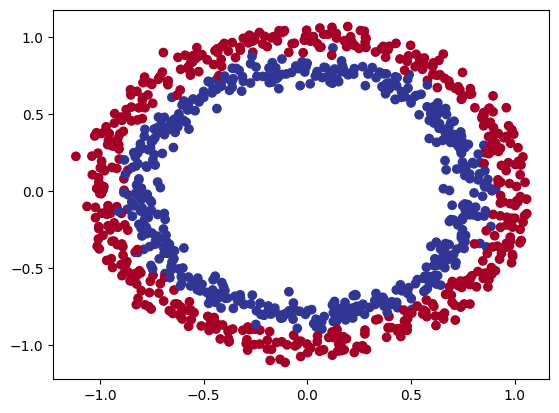

In [16]:
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

Although a toy example, many linear models will have trouble deal with this type of non-linear pattern. Neural Network models help us solve this type of issue as we will see in a bit.
<br>
<br>
Let's start by preparing our data for modelling:

In [17]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,
    random_state=42) 


X_train = torch.from_numpy(X_train).type(torch.float)
X_test = torch.from_numpy(X_test).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.float)

We can create a two layer linear model by inheriting from `nn.Module`:

In [18]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0()
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

Ideally, we can also use the elegant `nn.Sequential` abstraction:

In [19]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

Checking random `predictions` (of course, they suck as they are not even in the format expected by the labels):

In [21]:
untrained_preds = model_0(X_test)
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.5190],
        [-0.4092],
        [-0.6789],
        [-0.4671],
        [-0.5120],
        [-0.4431],
        [-0.2840],
        [-0.2897],
        [-0.6930],
        [-0.4092]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


Let's train a model to amend this:

In [22]:
# Binary Cross entropy - built in logic is recommmended
loss_fn = nn.BCEWithLogitsLoss()

# Stochastic Gradient Descent for Optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [23]:
# Accuracy function: 
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

Let's use a training loop for 100 epochs on our data:

In [25]:
torch.manual_seed(42)

epochs = 100


# Build training and evaluation loop
for epoch in range(epochs):

    model_0.train()

    y_logits = model_0(X_train).squeeze()
    
    loss = loss_fn(y_logits,
                   y_train) 
    
    # Calculating current accuracy
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=torch.round(torch.sigmoid(y_logits))) 

    # Training steps
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_0.eval()
    
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze() 
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=torch.round(torch.sigmoid(test_logits)))

    # Print out accuracy and loss
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.72725, Accuracy: 50.00% | Test loss: 0.72630, Test acc: 50.00%
Epoch: 10 | Loss: 0.70156, Accuracy: 50.00% | Test loss: 0.70135, Test acc: 50.00%
Epoch: 20 | Loss: 0.69578, Accuracy: 50.00% | Test loss: 0.69496, Test acc: 50.00%
Epoch: 30 | Loss: 0.69437, Accuracy: 46.12% | Test loss: 0.69322, Test acc: 46.00%
Epoch: 40 | Loss: 0.69394, Accuracy: 46.12% | Test loss: 0.69276, Test acc: 47.00%
Epoch: 50 | Loss: 0.69373, Accuracy: 47.50% | Test loss: 0.69269, Test acc: 49.00%
Epoch: 60 | Loss: 0.69360, Accuracy: 48.12% | Test loss: 0.69277, Test acc: 48.50%
Epoch: 70 | Loss: 0.69349, Accuracy: 48.00% | Test loss: 0.69289, Test acc: 47.00%
Epoch: 80 | Loss: 0.69341, Accuracy: 48.62% | Test loss: 0.69302, Test acc: 47.00%
Epoch: 90 | Loss: 0.69334, Accuracy: 49.62% | Test loss: 0.69316, Test acc: 45.50%


Training is barely moving the performance! That's because we are using a linear boundary, something that can't solve our "circles" problem.

We can try to do several things to improve our model, such as: 
* Add more layers
* Add more hidden units
* Fitting for more epochs
* Change optimizer
* Change the learning rate

Unfortunately, none of these will work as we are dealing with a special type fo problem that can't be split with a single line. We need the missing link to make our algorithm work, using non-linear activation functions!
<br>
<br>
We'll also add a new layer just to spice up our model:

In [49]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_with_relu = CircleModelV2()
print(model_with_relu)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


And let's train it!

In [50]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_with_relu.parameters(), lr=0.1)

In [51]:
torch.manual_seed(42)

epochs = 100


# Build training and evaluation loop
for epoch in range(epochs):

    model_with_relu.train()

    y_logits = model_with_relu(X_train).squeeze()
    
    loss = loss_fn(y_logits,
                   y_train) 
    
    # Calculating current accuracy
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=torch.round(torch.sigmoid(y_logits))) 

    # Training steps
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_with_relu.eval()
    
    with torch.inference_mode():
        test_logits = model_with_relu(X_test).squeeze() 
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=torch.round(torch.sigmoid(test_logits)))

    # Print out accuracy and loss
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test loss: 0.69329, Test acc: 50.00%
Epoch: 10 | Loss: 0.69251, Accuracy: 51.38% | Test loss: 0.69275, Test acc: 50.00%
Epoch: 20 | Loss: 0.69227, Accuracy: 59.75% | Test loss: 0.69246, Test acc: 55.50%
Epoch: 30 | Loss: 0.69212, Accuracy: 69.25% | Test loss: 0.69227, Test acc: 63.50%
Epoch: 40 | Loss: 0.69197, Accuracy: 66.12% | Test loss: 0.69210, Test acc: 68.50%
Epoch: 50 | Loss: 0.69183, Accuracy: 58.75% | Test loss: 0.69193, Test acc: 60.50%
Epoch: 60 | Loss: 0.69169, Accuracy: 55.12% | Test loss: 0.69179, Test acc: 54.50%
Epoch: 70 | Loss: 0.69156, Accuracy: 53.25% | Test loss: 0.69165, Test acc: 52.00%
Epoch: 80 | Loss: 0.69143, Accuracy: 52.88% | Test loss: 0.69152, Test acc: 51.50%
Epoch: 90 | Loss: 0.69130, Accuracy: 52.75% | Test loss: 0.69139, Test acc: 51.50%


It's doing something! Let's see what happens if we raise the epochs:

In [52]:
torch.manual_seed(42)

epochs = 1000


# Build training and evaluation loop
for epoch in range(epochs):

    model_with_relu.train()

    y_logits = model_with_relu(X_train).squeeze()
    
    loss = loss_fn(y_logits,
                   y_train) 
    
    # Calculating current accuracy
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=torch.round(torch.sigmoid(y_logits))) 

    # Training steps
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_with_relu.eval()
    
    with torch.inference_mode():
        test_logits = model_with_relu(X_test).squeeze() 
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=torch.round(torch.sigmoid(test_logits)))

    # Print out accuracy and loss
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69117, Accuracy: 52.75% | Test loss: 0.69126, Test acc: 52.50%
Epoch: 10 | Loss: 0.69104, Accuracy: 52.62% | Test loss: 0.69112, Test acc: 52.50%
Epoch: 20 | Loss: 0.69091, Accuracy: 52.38% | Test loss: 0.69098, Test acc: 54.00%
Epoch: 30 | Loss: 0.69078, Accuracy: 52.62% | Test loss: 0.69084, Test acc: 54.00%
Epoch: 40 | Loss: 0.69065, Accuracy: 52.38% | Test loss: 0.69070, Test acc: 54.00%
Epoch: 50 | Loss: 0.69051, Accuracy: 52.75% | Test loss: 0.69055, Test acc: 54.00%
Epoch: 60 | Loss: 0.69037, Accuracy: 52.75% | Test loss: 0.69040, Test acc: 54.00%
Epoch: 70 | Loss: 0.69023, Accuracy: 52.75% | Test loss: 0.69025, Test acc: 54.00%
Epoch: 80 | Loss: 0.69008, Accuracy: 53.00% | Test loss: 0.69009, Test acc: 53.50%
Epoch: 90 | Loss: 0.68993, Accuracy: 53.25% | Test loss: 0.68993, Test acc: 53.50%
Epoch: 100 | Loss: 0.68978, Accuracy: 54.25% | Test loss: 0.68976, Test acc: 54.50%
Epoch: 110 | Loss: 0.68961, Accuracy: 54.50% | Test loss: 0.68958, Test acc: 54.50%
Epo